# Лабораторная работа №7
## ЧАСТОТНО-ВРЕМЕННЫЕ ХАРАКТЕРИСТИКИ ВРЕМЕННЫХ РЯДОВ
### Котов Иван Юрьевич
### Вариант: 14
### Группа: РИМ-181226

In [91]:
import numpy as np
import numpy.random as rand
import matplotlib.pyplot as plt
from scipy import signal
import scipy
from sklearn.linear_model import LinearRegression
from scipy.optimize import curve_fit


%matplotlib inline

Создадим временной ряд с ЛЧМ (линейной частотной модуляцией) в
диапазоне от 50 до 150 Гц:

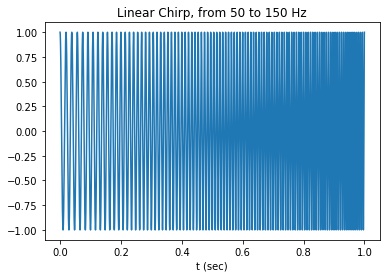

In [5]:
tx = np.linspace(0, 1, 8192) # временной отрезок от 0 до 1 сек
w = signal.chirp(tx, f0 = 50, f1 = 150, t1 = 1, method='linear')
# от 50 до 150 Гц за 1 секунду, ЛЧМ
plt.plot(tx, w)
plt.title("Linear Chirp, from 50 to 150 Hz")
plt.xlabel('t (sec)')
plt.show()

Построим спектрограмму заданного ряда, чтобы вычислить его
частотно-временные характеристики. Для этого сначала нам
потребуется рассчитать его частоту дискретизации:

In [6]:
fs = 1/(tx[1] - tx[0]) # fs = 1/dt = N/T

Строим спектрограмму по умолчанию:

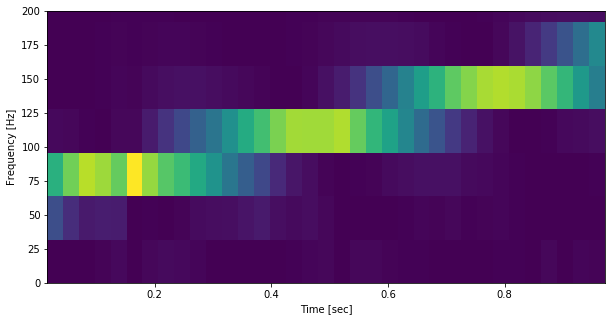

In [7]:
f, t, Sxx = signal.spectrogram(w, fs) # возвращаем частоту от времени
plt.figure(figsize = (10, 5))
plt.pcolormesh(t, f, Sxx) # цвет – интенсивность спектрограммы
plt.ylabel('Frequency [Hz]')
plt.ylim(0, 200) # строим до 200 Гц, иначе будет до fs/2
plt.xlabel('Time [sec]')
plt.show()

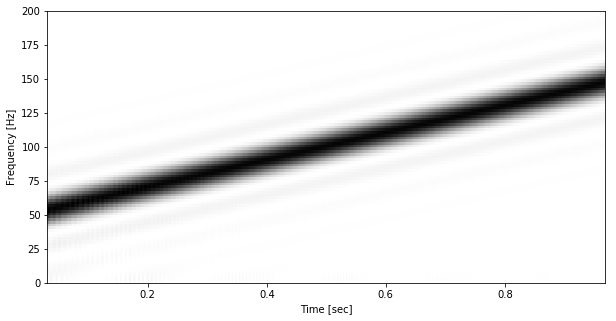

In [8]:
f, t, Sxx = signal.spectrogram(w, fs, nperseg = 512, noverlap = 496, nfft=4096)
# длина каждого сегмента = 512, число пересекающихся точек между
#сегментами = 496, длина FFT = 4096
plt.figure(figsize = (10, 5))
plt.pcolormesh(t, f, Sxx, cmap='gray_r') # в оттенках серого цвета
plt.ylabel('Frequency [Hz]')
plt.ylim(0, 200)
plt.xlabel('Time [sec]')
plt.show()

In [277]:
def get_spectr(w, fs):

    f, t, Sxx = signal.spectrogram(w, fs, nperseg = 512, noverlap = 496, nfft=4096)
    # длина каждого сегмента = 512, число пересекающихся точек между
    #сегментами = 496, длина FFT = 4096
    plt.figure(figsize = (10, 5))
    plt.pcolormesh(t, f, Sxx, cmap='gray_r') # в оттенках серого цвета
    plt.ylabel('Frequency [Hz]')
    plt.ylim(0, 200)
    plt.xlabel('Time [sec]')
    plt.show()

Полученная черно-белая картина спектрограммы гораздо лучше
отражает линейную структуру частотной модуляции, как и ее
диапазон. Тем не менее, для оценки диапазона частотной модуляции
хотелось бы иметь более точный численный инструмент – таковым
является Преобразование Гильберта. 

Преобразование Гильберта позволяет однозначно определить понятие аналитического сигнала, через который можно определить и функцию амплитудной модуляции (АМ, мгновенная амплитуда), и функцию фазы, и функцию мгновенной частоты (instantaneous frequency), как производную от мгновенной фазы, то есть как раз искомую зависимость частоты от времени для ЧМ.

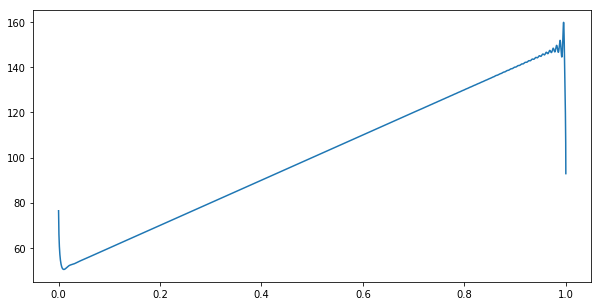

In [9]:
analytic_signal = signal.hilbert(w) # аналитический сигнал
instantaneous_phase = np.unwrap(np.angle(analytic_signal))
# мгновенная фаза в развернутом непрерывном виде

instantaneous_frequency = (np.diff(instantaneous_phase) / (2.0*np.pi) * fs)
# мгновенная частота как производная от фазы, приведенная в Гц
plt.figure(figsize = (10, 5))

# из-за численного расчета производной массив мгновенной частоты
# будет меньше массива времени на одну точку:
plt.plot(tx[1:], instantaneous_frequency)
plt.show()

Полученный график имеет четко выраженную линейную форму
частоты от 50 до 150 Гц, за исключением краевых эффектов, которые
все портят. Эти краевые искажения связаны с численным расчетом
производной от мгновенной частоты и на практике для избавления от
них полученный ряд сглаживают скользящим средним или
регрессионной кривой. 

Поэтому, на основе Ваших навыков из лабораторной работы №3
постройте линейный тренд для мгновенной частоты
instantaneous_frequency по методу линейной регрессии и по методу
скользящего среднего сглаживания. Оцените диапазон частоты
(значение частоты в начальной и конечной точках) в обоих случаях.

### Линейная регрессия

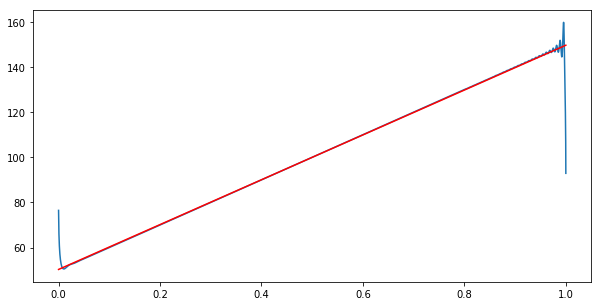

Диапазон частоты [50.30, 149.68]


In [34]:
reg = LinearRegression().fit(tx[1:].reshape(-1,1), instantaneous_frequency)
lr = reg.intercept_ + np.multiply(reg.coef_, tx[1:])

plt.figure(figsize = (10, 5))
plt.plot(tx[1:],instantaneous_frequency) # строим исходный ВР
plt.plot(tx[1:], lr, 'r') # строим его тренд
plt.show()
print("Диапазон частоты [%1.2f, %1.2f]"%(lr[0], lr[-1]))

### Метод скользящего среднего сглаживания

In [17]:
def smooth(x, window_len):
    
    if window_len<3:
        return x

    s=np.r_[2*x[0]-x[window_len-1::-1], x, 2*x[-1]-x[-1:-window_len:-1]]
    w=np.ones(window_len, 'd')
    y=np.convolve(w/w.sum(), s, mode='same')
    
    return y[window_len:-window_len+1]

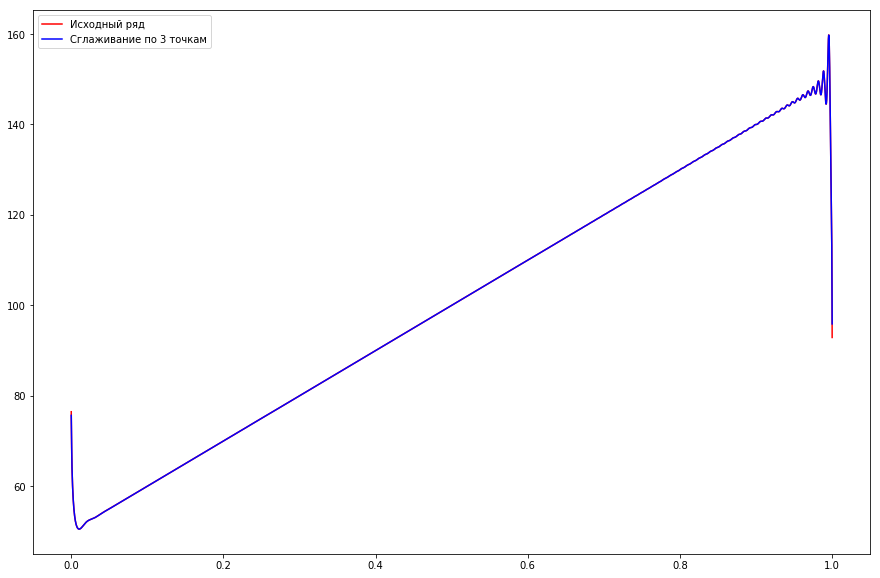

Диапазон частоты [75.66, 95.90]


In [43]:
smoothed_data = smooth(instantaneous_frequency, 3) 

plt.figure(figsize = (15,10))
plt.plot(tx[1:], instantaneous_frequency, 'r', label = 'Исходный ряд')
plt.plot(tx[1:], smoothed_data, 'b', label = 'Сглаживание по 3 точкам')
plt.legend()
plt.show()
print("Диапазон частоты [%1.2f, %1.2f]"%(smoothed_data[0], smoothed_data[-1]))

Теперь, когда нам известно, как оценить частотно-временные
характеристики ряда, постройте зависимость частоты от времени для
следующих модельных временных рядов через спектрограмму и
преобразование Гильберта, не забывая сглаживать мгновенную
частоту регрессионной кривой:

In [61]:
def get_if(tx,w):

    analytic_signal = signal.hilbert(w) # аналитический сигнал
    instantaneous_phase = np.unwrap(np.angle(analytic_signal))# мгновенная фаза в развернутом непрерывном виде
    instantaneous_frequency = (np.diff(instantaneous_phase) / (2.0*np.pi) * fs)
    
    return instantaneous_frequency

### ЛЧМ в большем диапазоне

In [ ]:
get_spectr()

In [56]:
tx = np.linspace(0, 1, 8192) # ЛЧМ в большем диапазоне
w = signal.chirp(tx, f0=200, f1=3000, t1=1, method='linear')

#### Линейная регрессия

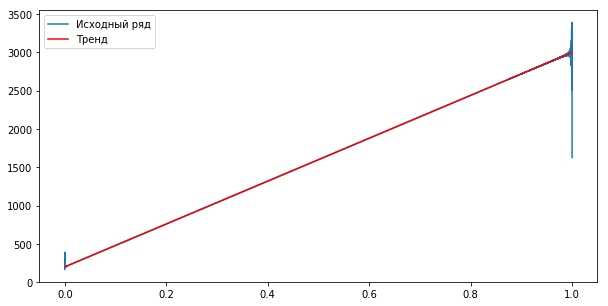

Диапазон частоты [200.61, 2999.20]


In [62]:
instantaneous_frequency = get_if(tx,w)
reg = LinearRegression().fit(tx[1:].reshape(-1,1), instantaneous_frequency)
lr = reg.intercept_ + np.multiply(reg.coef_, tx[1:])

plt.figure(figsize = (10, 5))
plt.plot(tx[1:],instantaneous_frequency, label = 'Исходный ряд') # строим исходный ВР
plt.plot(tx[1:], lr, 'r', label = 'Тренд') # строим его тренд
plt.legend()
plt.show()
print("Диапазон частоты [%1.2f, %1.2f]"%(lr[0], lr[-1]))

### Ряд с квадратичной частотной модуляцией:

In [82]:
tx = np.linspace(0, 1, 8192)
w = signal.chirp(tx, f0=2000, f1=200, t1=1, method='quadratic')

#### Линейная регрессия

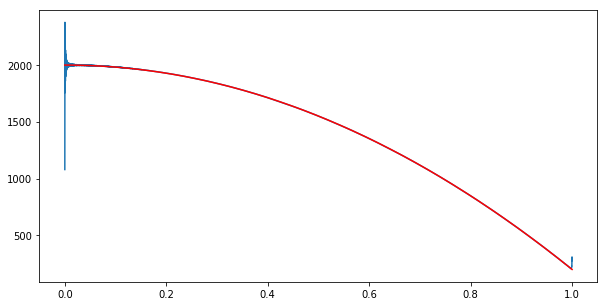

Диапазон частоты [1999.12, 200.32]


In [83]:
instantaneous_frequency = get_if(tx,w)
time_stacked_2 = np.vstack((np.vstack((np.ones(len(tx)), tx)),np.square(tx))).T
reg = LinearRegression().fit(time_stacked_2[1:], instantaneous_frequency)
lr = reg.intercept_ + np.multiply(reg.coef_[1], tx[1:])\
         + np.multiply(reg.coef_[2], np.square(tx[1:]))

plt.figure(figsize = (10, 5))
plt.plot(tx[1:],instantaneous_frequency, label = 'Исходный ряд') # строим исходный ВР
plt.plot(tx[1:], lr, 'r', label = 'Тренд') # строим его тренд
plt.legend()
plt.show()
print("Диапазон частоты [%1.2f, %1.2f]"%(lr[0], lr[-1]))

### Ряд с инверсной квадратичной частотной модуляцией:

In [86]:
tx = np.linspace(0, 1, 8192)
w = signal.chirp(tx, f0=3200, f1=400, t1=1, method='quadratic', vertex_zero=False)

#### Линейная регрессия

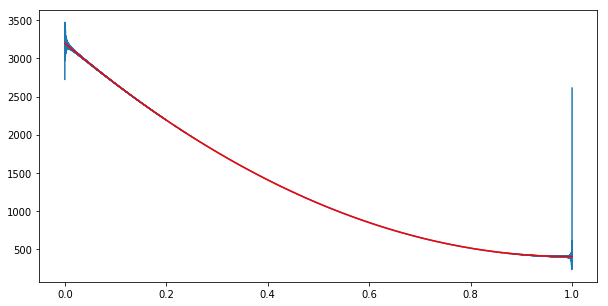

Диапазон частоты [3200.18, 402.42]


In [87]:
instantaneous_frequency = get_if(tx,w)
time_stacked_2 = np.vstack((np.vstack((np.ones(len(tx)), tx)),np.square(tx))).T
reg = LinearRegression().fit(time_stacked_2[1:], instantaneous_frequency)
lr = reg.intercept_ + np.multiply(reg.coef_[1], tx[1:])\
         + np.multiply(reg.coef_[2], np.square(tx[1:]))

plt.figure(figsize = (10, 5))
plt.plot(tx[1:],instantaneous_frequency, label = 'Исходный ряд') # строим исходный ВР
plt.plot(tx[1:], lr, 'r', label = 'Тренд') # строим его тренд
plt.legend()
plt.show()
print("Диапазон частоты [%1.2f, %1.2f]"%(lr[0], lr[-1]))

### Ряд с логарифмической частотной модуляцией:

In [158]:
tx = np.linspace(0, 1, 8192)
w = signal.chirp(tx, f0=2450, f1=300, t1=1, method='logarithmic')

#### Метод скользящего среднего сглаживания¶

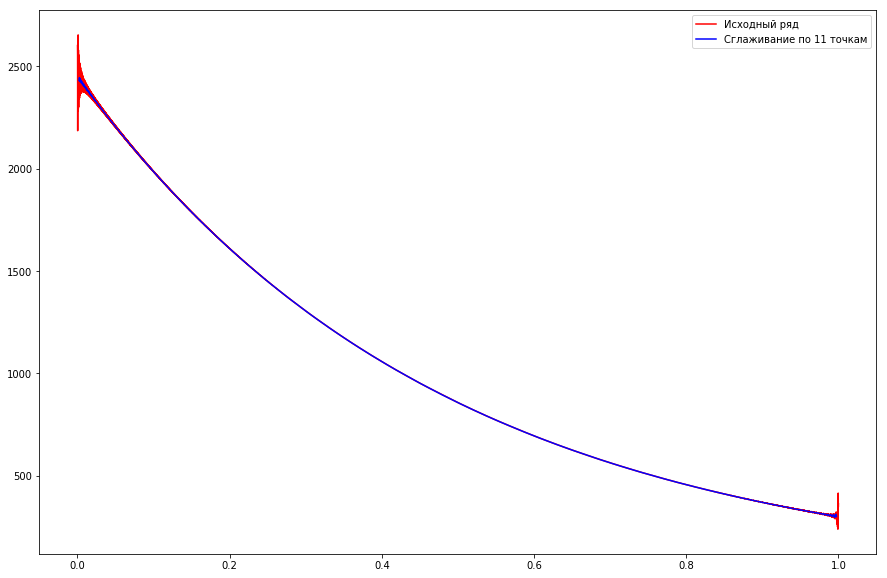

Диапазон частоты [2430.67, 300.52]


In [159]:
instantaneous_frequency = get_if(tx,w)

cut = 20
smoothed_data = smooth(instantaneous_frequency, 11)[cut:-cut]
tx_cut = tx[cut:-(cut+1)]

plt.figure(figsize = (15,10))
plt.plot(tx[1:], instantaneous_frequency, 'r', label = 'Исходный ряд')
plt.plot(tx_cut, smoothed_data, 'b', label = 'Сглаживание по 11 точкам')
plt.legend()
plt.show()
print("Диапазон частоты [%1.2f, %1.2f]"%(smoothed_data[0], smoothed_data[-1]))

### Ряд с гиперболической частотной модуляцией

In [160]:
tx = np.linspace(0, 1, 8192)
w = signal.chirp(tx, f0=1500, f1=250, t1=1, method='hyperbolic')

#### Метод скользящего среднего сглаживания¶

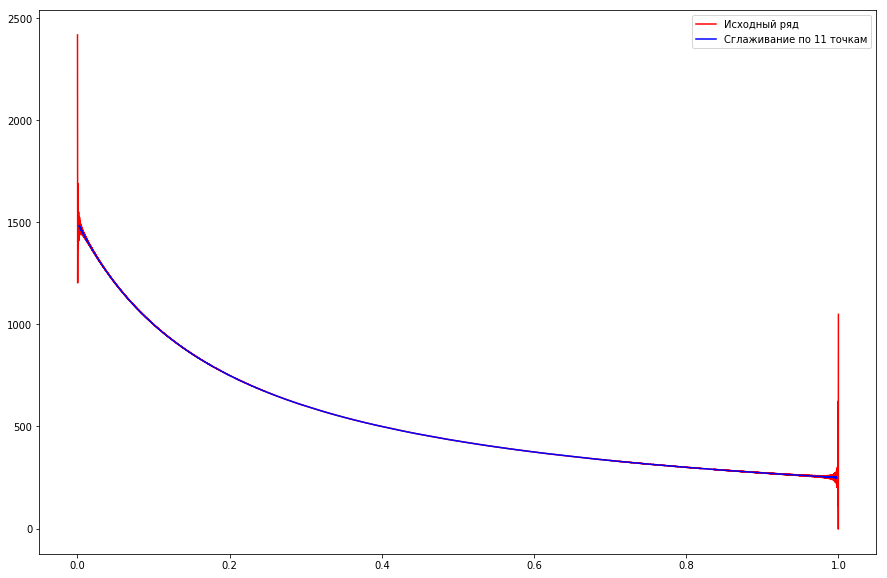

Диапазон частоты [1481.84, 251.42]


In [161]:
instantaneous_frequency = get_if(tx,w)

cut = 20
smoothed_data = smooth(instantaneous_frequency, 11)[cut:-cut]
tx_cut = tx[cut:-(cut+1)]

plt.figure(figsize = (15,10))
plt.plot(tx[1:], instantaneous_frequency, 'r', label = 'Исходный ряд')
plt.plot(tx_cut, smoothed_data, 'b', label = 'Сглаживание по 11 точкам')
plt.legend()
plt.show()
print("Диапазон частоты [%1.2f, %1.2f]"%(smoothed_data[0], smoothed_data[-1]))

### Ряд с полиномиальной частотной модуляцией

In [163]:
tx = np.linspace(0, 10, 8192)
p = np.poly1d([2.5, -36.0, 125.0, 150.0])
w = signal.sweep_poly(tx, p)

#### Метод скользящего среднего сглаживания¶

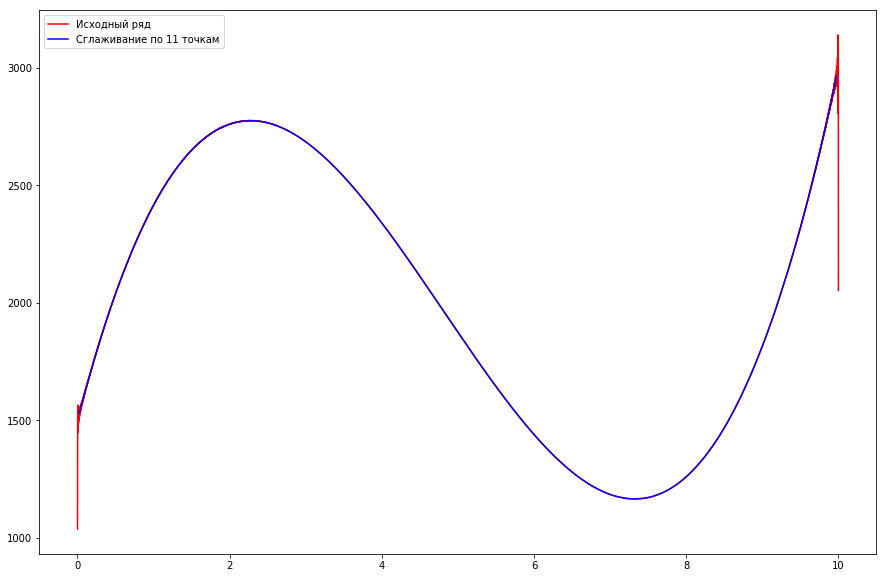

Диапазон частоты [1531.47, 2962.27]


In [164]:
instantaneous_frequency = get_if(tx,w)

cut = 20
smoothed_data = smooth(instantaneous_frequency, 11)[cut:-cut]
tx_cut = tx[cut:-(cut+1)]

plt.figure(figsize = (15,10))
plt.plot(tx[1:], instantaneous_frequency, 'r', label = 'Исходный ряд')
plt.plot(tx_cut, smoothed_data, 'b', label = 'Сглаживание по 11 точкам')
plt.legend()
plt.show()
print("Диапазон частоты [%1.2f, %1.2f]"%(smoothed_data[0], smoothed_data[-1]))

### Ряд с частотной модуляцией другим гармоническим сигналом

In [165]:
tx = np.linspace(0, 10, 2*8192)
mod = 500*np.cos(2*np.pi*0.25*tx)
w = 2 * np.sqrt(2) * np.sin(2*np.pi*300*tx + mod)

#### Метод скользящего среднего сглаживания¶

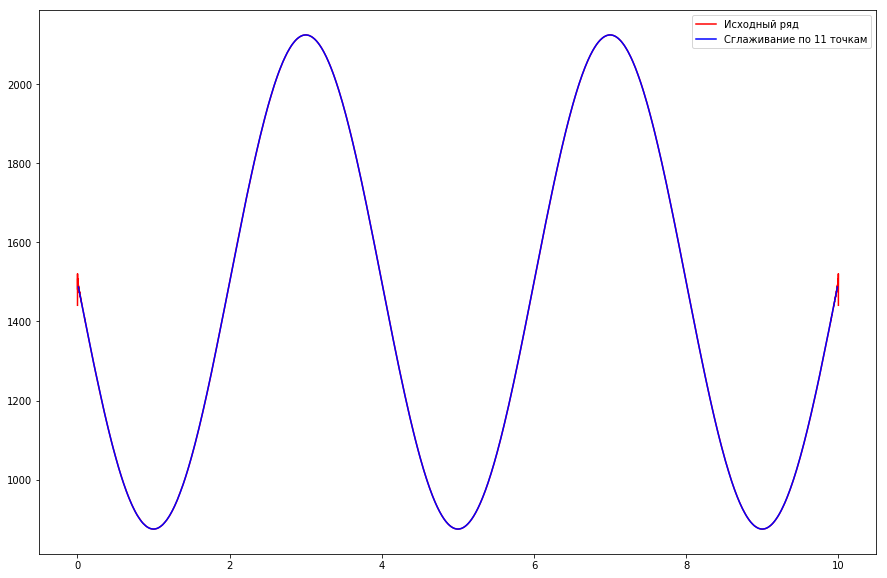

Диапазон частоты [1487.26, 1487.26]


In [166]:
instantaneous_frequency = get_if(tx,w)

cut = 20
smoothed_data = smooth(instantaneous_frequency, 11)[cut:-cut]
tx_cut = tx[cut:-(cut+1)]

plt.figure(figsize = (15,10))
plt.plot(tx[1:], instantaneous_frequency, 'r', label = 'Исходный ряд')
plt.plot(tx_cut, smoothed_data, 'b', label = 'Сглаживание по 11 точкам')
plt.legend()
plt.show()
print("Диапазон частоты [%1.2f, %1.2f]"%(smoothed_data[0], smoothed_data[-1]))

### Ряд с частотным изломом:

In [168]:
tx = np.linspace(0, 1, 4096)
w = np.zeros(4096)
for i in range(0, len(tx)//2):
    w[i] = np.sin(2*np.pi*100*tx[i])
for i in range(len(tx)//2, len(tx)):
    w[i] = np.sin(2*np.pi*1200*tx[i])

#### Метод скользящего среднего сглаживания¶

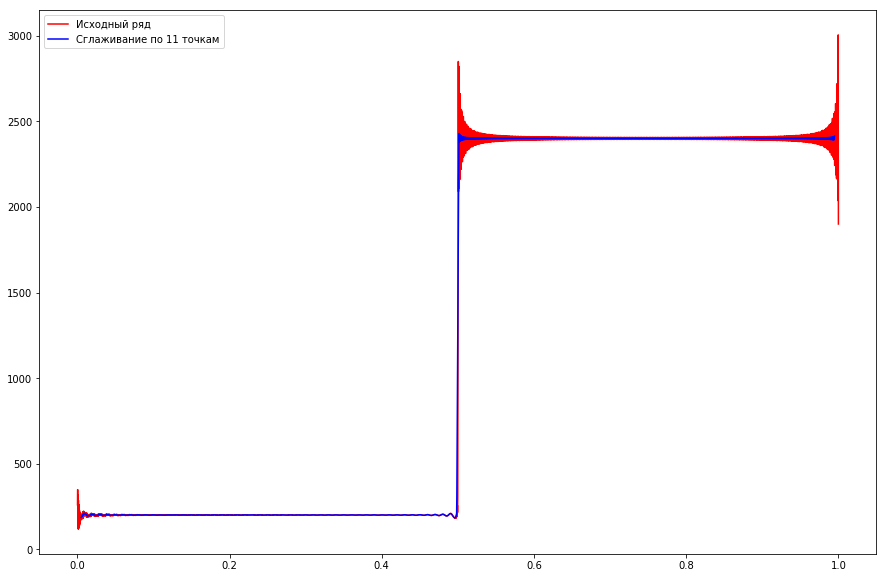

Диапазон частоты [185.84, 2414.28]


In [169]:
instantaneous_frequency = get_if(tx,w)

cut = 20
smoothed_data = smooth(instantaneous_frequency, 11)[cut:-cut]
tx_cut = tx[cut:-(cut+1)]

plt.figure(figsize = (15,10))
plt.plot(tx[1:], instantaneous_frequency, 'r', label = 'Исходный ряд')
plt.plot(tx_cut, smoothed_data, 'b', label = 'Сглаживание по 11 точкам')
plt.legend()
plt.show()
print("Диапазон частоты [%1.2f, %1.2f]"%(smoothed_data[0], smoothed_data[-1]))

### Временной ряд из 4 гармоник без шума

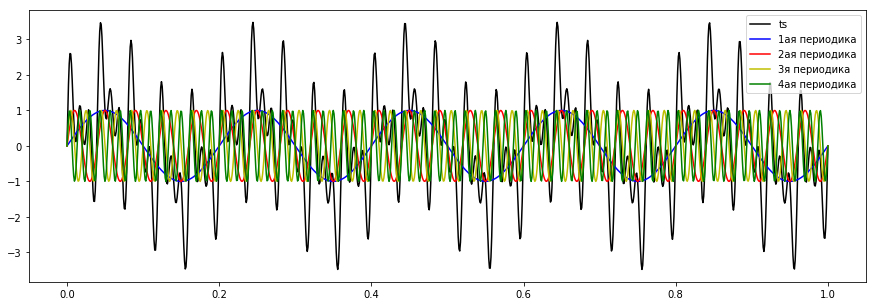

In [266]:
tx = np.linspace(0, 1, 1024)
f1 = 5
f2 = 25
f3 = 50
f4 = 75
w = np.sin(2*np.pi*f1*tx) + np.sin(2*np.pi*f2*tx) \
    + np.sin(2*np.pi*f3*tx) + np.sin(2*np.pi*f4*tx)

plt.figure(figsize = (15, 5))
plt.plot(tx, w, 'k', label = 'ts')
plt.plot(tx, np.sin(2*np.pi*f1*tx), 'b', label = '1ая периодика')
plt.plot(tx, np.sin(2*np.pi*f2*tx), 'r', label = '2ая периодика')
plt.plot(tx, np.sin(2*np.pi*f3*tx), 'y', label = '3я периодика')
plt.plot(tx, np.sin(2*np.pi*f4*tx), 'g', label = '4ая периодика')
plt.legend()
plt.show()

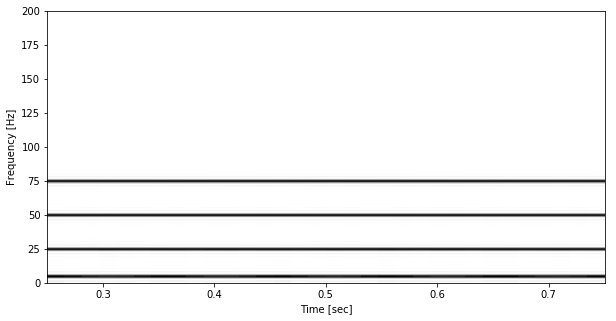

In [278]:
fs = 1/(tx[1] - tx[0]) # fs = 1/dt = N/T
f, t, Sxx = signal.spectrogram(w, fs, nperseg = 512, noverlap = 496, nfft=4096)
# длина каждого сегмента = 512, число пересекающихся точек между
#сегментами = 496, длина FFT = 4096
plt.figure(figsize = (10, 5))
plt.pcolormesh(t, f, Sxx, cmap='gray_r') # в оттенках серого цвета
plt.ylabel('Frequency [Hz]')
plt.ylim(0, 200)
plt.xlabel('Time [sec]')
plt.show()

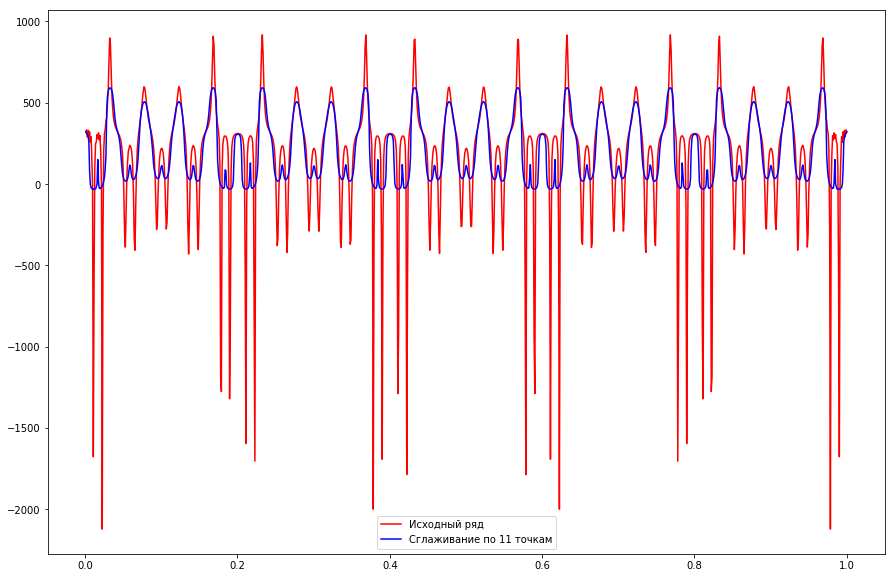

Диапазон частоты [320.46, 320.46]


In [267]:
instantaneous_frequency = get_if(tx,w)

smoothed_data = smooth(instantaneous_frequency, 11)

plt.figure(figsize = (15,10))
plt.plot(tx[1:], instantaneous_frequency, 'r', label = 'Исходный ряд')
plt.plot(tx[1:], smoothed_data, 'b', label = 'Сглаживание по 11 точкам')
plt.legend()
plt.show()
print("Диапазон частоты [%1.2f, %1.2f]"%(smoothed_data[0], smoothed_data[-1]))

В случае с последним временным рядом из нескольких периодик
для Преобразования Гильберта должен получиться неожиданный
результат – нечто совершенно не похожее ни коим образом на 4
разных, но постоянных периода. Связано это с тем, что сумма
гармоник трактуется через Преобразование Гильберта как единый
аналитический сигнал с некоторой сложной амплитудной
модуляцией (сумма синусов может быть записана как произведение
синуса на косинус).


По этой причине, прежде чем применять метод аналитического
сигнала и расчета мгновенной частоты, исходный временной ряд
всегда сначала раскладывают в аддитивную сумму компонент в
разных частотных областях. На уже известны несколько подобных
методов – регрессия, сингулярный спектральный анализ, вейвлетдекомпозиция и т.д. В этот раз мы используем адаптивный метод
Эмпирической Модовой Декомпозиции.

И так, Ваше новое задание – реализовать базовый метод
Эмпирической Модовой Декомпозиции (ЭМД) в Python, блок-схема
представлена ниже.

# Эмпирическая Модовая Декомпозиция

Кратко, суть метода – провести огибающие кривые в виде кубических сплайнов через максимумы (верхняя кривая) и минимумы (нижняя кривая) ряда, найти их среднее и вычесть из ряда (повторить 10 раз). Полученный остаток принять за компоненту, вычесть из ряда и начать все заново, пока не получатся все желаемые компоненты.

In [22]:
import scipy as sp
from scipy import signal

In [273]:
def get_emd(x, n_components = 3):
    
    r = x
    rr = r
    t = np.arange(len(r))
    components = np.zeros(n_components + 1, dtype=object)
    for i in range(n_components):
        r_tmp = r
        for j in range(10):
            up_dots = scipy.signal.argrelmax(r_tmp)[0]
            low_dots = scipy.signal.argrelmin(r_tmp)[0]
            
            up_dots_r = r_tmp[up_dots]
            fip = scipy.interpolate.CubicSpline(up_dots,up_dots_r)
            up_dots_t = fip(t)

            low_dots_r = r_tmp[low_dots]
            fitr = scipy.interpolate.CubicSpline(low_dots,low_dots_r)
            low_dots_t = fitr(t)

            mean_t = (up_dots_t + low_dots_t) / 2
            
            samp_start = np.max((np.min(up_dots),np.min(low_dots)))
            samp_end = np.min((np.max(up_dots),np.max(low_dots))) + 1
            mean_t[:samp_start] = mean_t[samp_start]
            mean_t[samp_end:] = mean_t[samp_end]
            
            r_tmp = r_tmp - mean_t                
        
        components[i] = r_tmp
        r = r - components[i] 
    
    components[n_components] = r
    return components

def plot_emd(x, tx, n_components, cut, window_len):
    
    components = get_emd(x, n_components)
    plt.figure(figsize=(16,8))
    for i in range(len(components)):
        
        plt.subplot(len(components),2,i*2+1)
        plt.plot(tx, x,color='0.6', label = 'F')
        plt.plot(tx, components[i],'k', label = 'component')
        plt.ylabel('component '+np.str(i+1))
        
        plt.subplot(len(components),2,i*2+2)
        instantaneous_frequency = get_if(tx, components[i])
        plt.plot(tx[1:], instantaneous_frequency, label = 'instantaneous_frequency', alpha = 0.5)
        
        smoothed_data = smooth(instantaneous_frequency, 21)[cut:-cut]
        tx_cut = tx[cut:-(cut+1)]
        
        print("Среднее тренда %1i: %1.2f"%(i,np.mean(smoothed_data)))
        
        plt.plot(tx_cut, smoothed_data, 'b', label = 'Сглаживание по 11 точкам')
        
    plt.tight_layout()
    plt.legend()

## Временной ряд из 2 периодик без шума:

Среднее тренда 0: 320.24
Среднее тренда 1: 80.03
Среднее тренда 2: 23.16


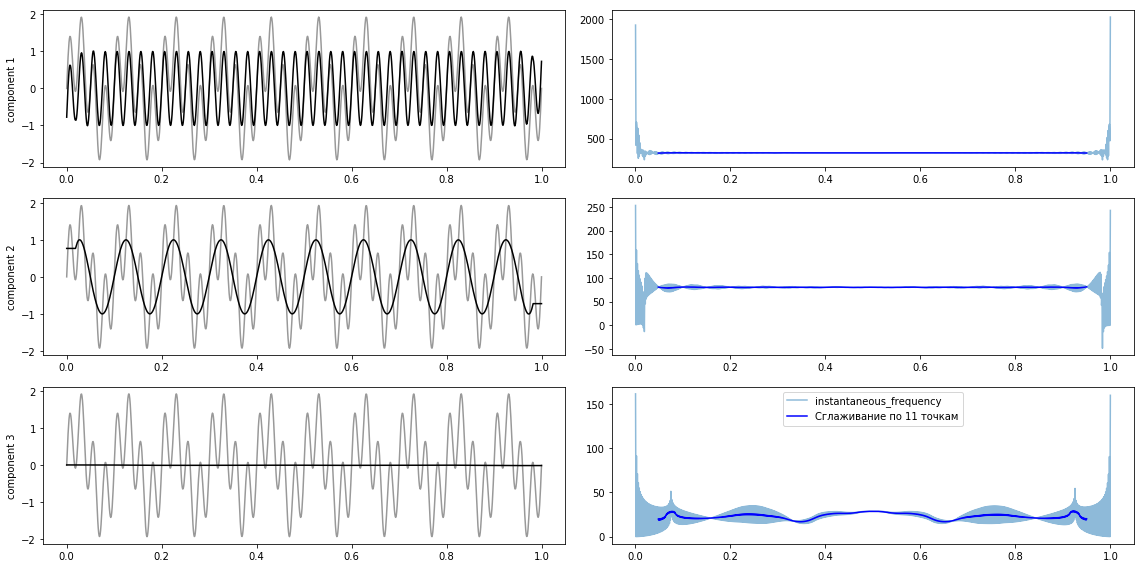

In [274]:
t = np.linspace(0, 1, 1024)
f1 = 10
f2 = 40
F =np.sin(2*np.pi*f1*t)+np.sin(2*np.pi*f2*t)
plot_emd(F, t, 2, 50, 51)

## Временной ряд из 2 периодик с шумом:

Среднее тренда 0: 303.17
Среднее тренда 1: 126.72
Среднее тренда 2: 57.94


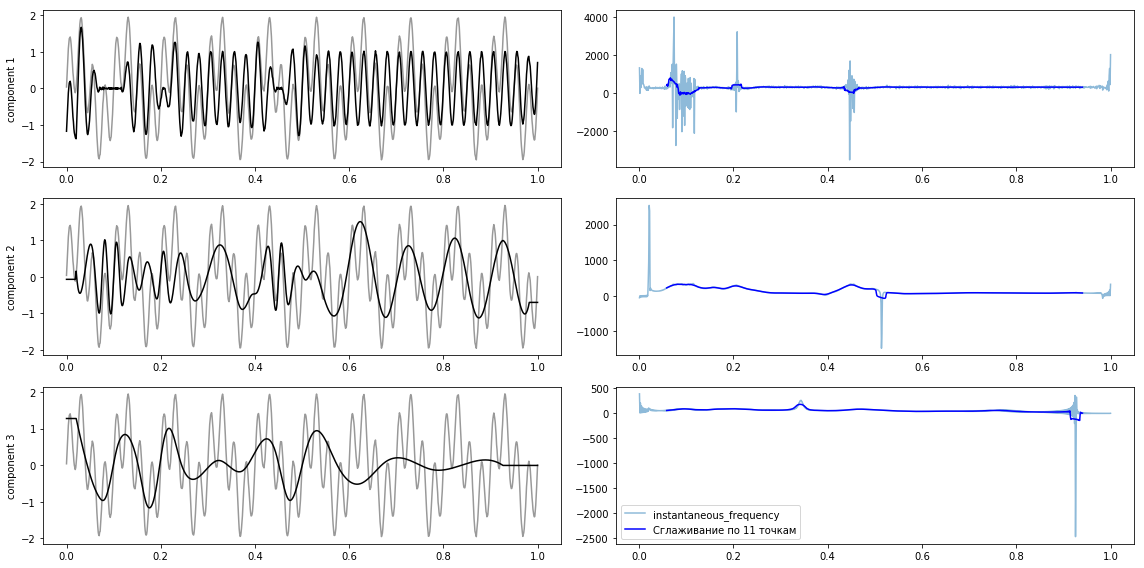

In [253]:
t = np.linspace(0, 1, 1024)
f1 = 10
f2 = 40
F=np.sin(2*np.pi*f1*t) + np.sin(2*np.pi*f2*t) + 0.02*rand.randn(len(t))
plot_emd(F, t, 2, 60, 101)

## Временной ряд из 4 гармоник без шума:

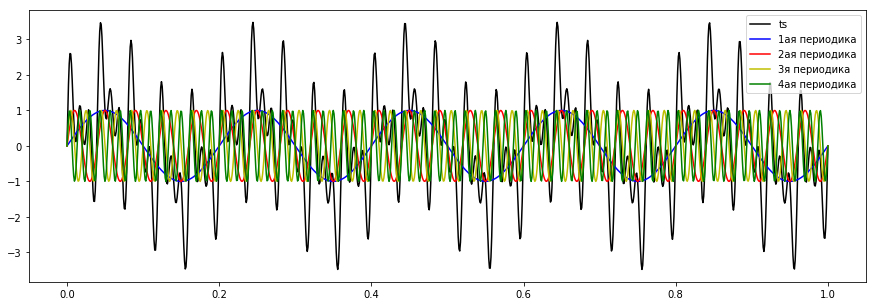

Среднее тренда 0: 601.63
Среднее тренда 1: 393.82
Среднее тренда 2: 195.28
Среднее тренда 3: 41.12
Среднее тренда 4: 24.19


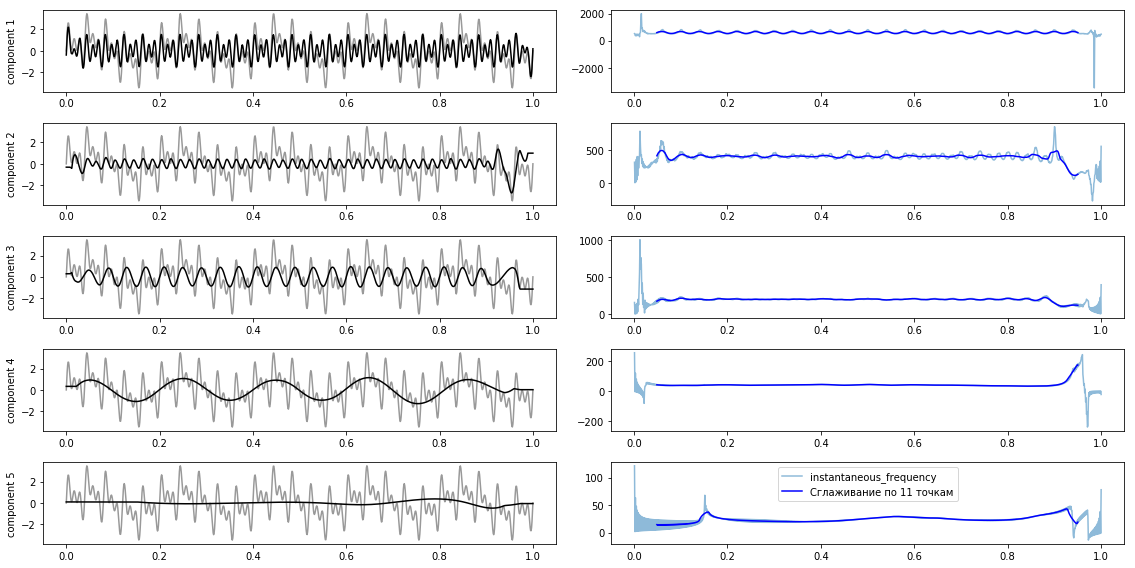

In [270]:
tx = np.linspace(0, 1, 1024)
f1 = 5
f2 = 25
f3 = 50
f4 = 75
w = np.sin(2*np.pi*f1*tx) + np.sin(2*np.pi*f2*tx) \
    + np.sin(2*np.pi*f3*tx) + np.sin(2*np.pi*f4*tx)


plt.figure(figsize = (15, 5))
plt.plot(tx, w, 'k', label = 'ts')
plt.plot(tx, np.sin(2*np.pi*f1*tx), 'b', label = '1ая периодика')
plt.plot(tx, np.sin(2*np.pi*f2*tx), 'r', label = '2ая периодика')
plt.plot(tx, np.sin(2*np.pi*f3*tx), 'y', label = '3я периодика')
plt.plot(tx, np.sin(2*np.pi*f4*tx), 'g', label = '4ая периодика')
plt.legend()
plt.show()
plot_emd(w, tx, 4, 50, 101)

## Временной ряд из 4 гармоник с шумом:

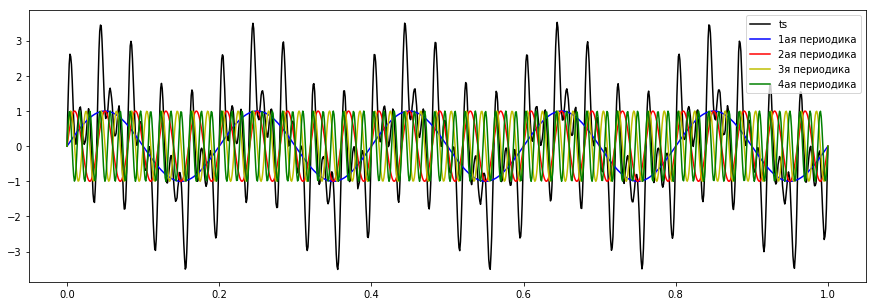

Среднее тренда 0: 601.54
Среднее тренда 1: 399.36
Среднее тренда 2: 198.63
Среднее тренда 3: 43.01
Среднее тренда 4: 23.69


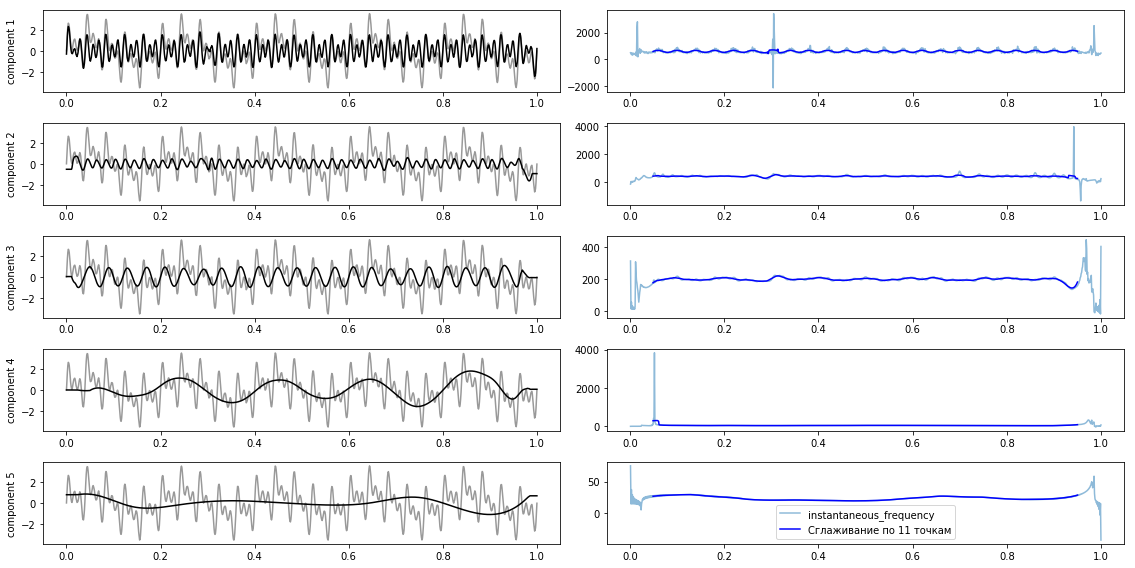

In [271]:
tx = np.linspace(0, 1, 1024)
f1 = 5
f2 = 25
f3 = 50
f4 = 75
w = np.sin(2*np.pi*f1*tx) + np.sin(2*np.pi*f2*tx) \
    + np.sin(2*np.pi*f3*tx) + np.sin(2*np.pi*f4*tx) + 0.03*rand.randn(len(tx))


plt.figure(figsize = (15, 5))
plt.plot(tx, w, 'k', label = 'ts')
plt.plot(tx, np.sin(2*np.pi*f1*tx), 'b', label = '1ая периодика')
plt.plot(tx, np.sin(2*np.pi*f2*tx), 'r', label = '2ая периодика')
plt.plot(tx, np.sin(2*np.pi*f3*tx), 'y', label = '3я периодика')
plt.plot(tx, np.sin(2*np.pi*f4*tx), 'g', label = '4ая периодика')
plt.legend()
plt.show()
plot_emd(w, tx, 4, 50, 101)

Аналогично, попробуйте провести декомпозицию следующих
временных рядов: с изломом частоты (см. пункт 16), случайный ряд
белого шума с нормальным распределением, экспоненциальный
зашумленный тренд:
## Ряд с частотным изломом:

Среднее тренда 0: 1300.15
Среднее тренда 1: 510.41


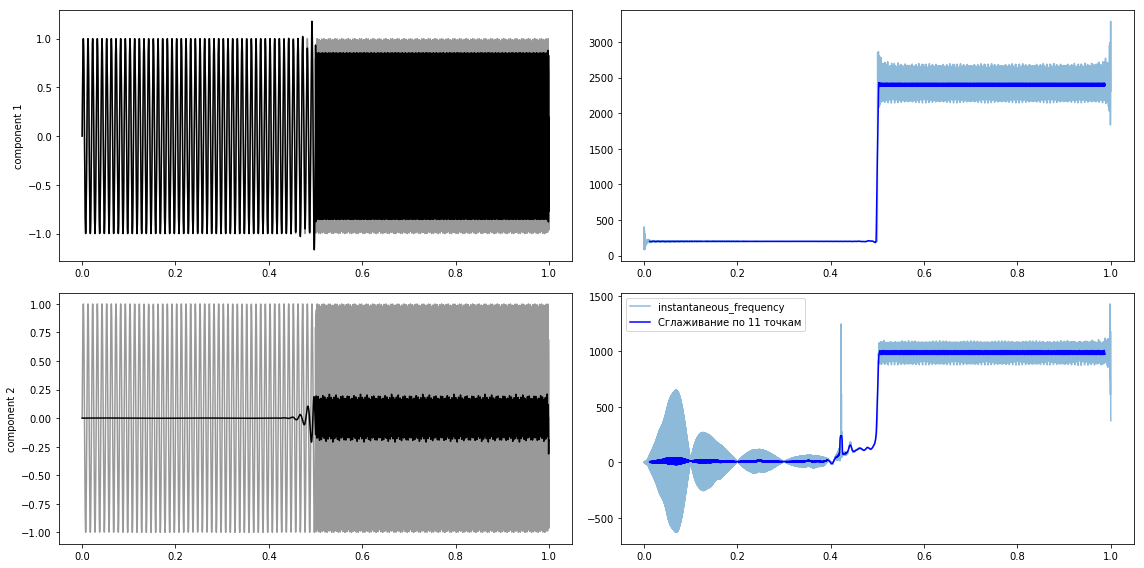

In [256]:
t = np.linspace(0, 1, 4096)
F = np.zeros(4096)

for i in range(0, len(t)//2):
    F[i] = np.sin(2*np.pi*100*t[i])
for i in range(len(t)//2, len(t)):
    F[i] = np.sin(2*np.pi*1200*t[i])

plot_emd(F, t, 1, 50, 51)

## Cлучайный ряд белого шума с нормальным распределением

Среднее тренда 0: 2172.21
Среднее тренда 1: 1357.55
Среднее тренда 2: 662.80
Среднее тренда 3: 314.18
Среднее тренда 4: 163.60
Среднее тренда 5: 52.89


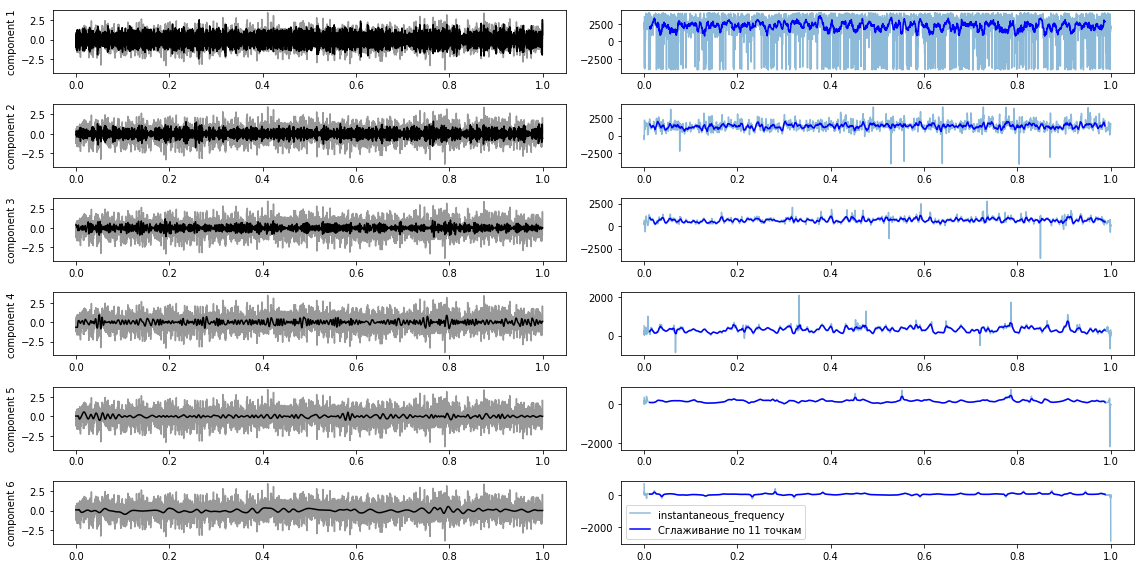

In [258]:
t = np.linspace(0, 1, 4096)
mean = 0
std = 1
F = np.random.normal(mean, std, size=4096)
plot_emd(F, t, 5, 50, 515)

### Экспоненциальный зашумленный тренд

Среднее тренда 0: 2150.72
Среднее тренда 1: 1323.15
Среднее тренда 2: 646.84
Среднее тренда 3: 324.57
Среднее тренда 4: 169.34
Среднее тренда 5: 9.94


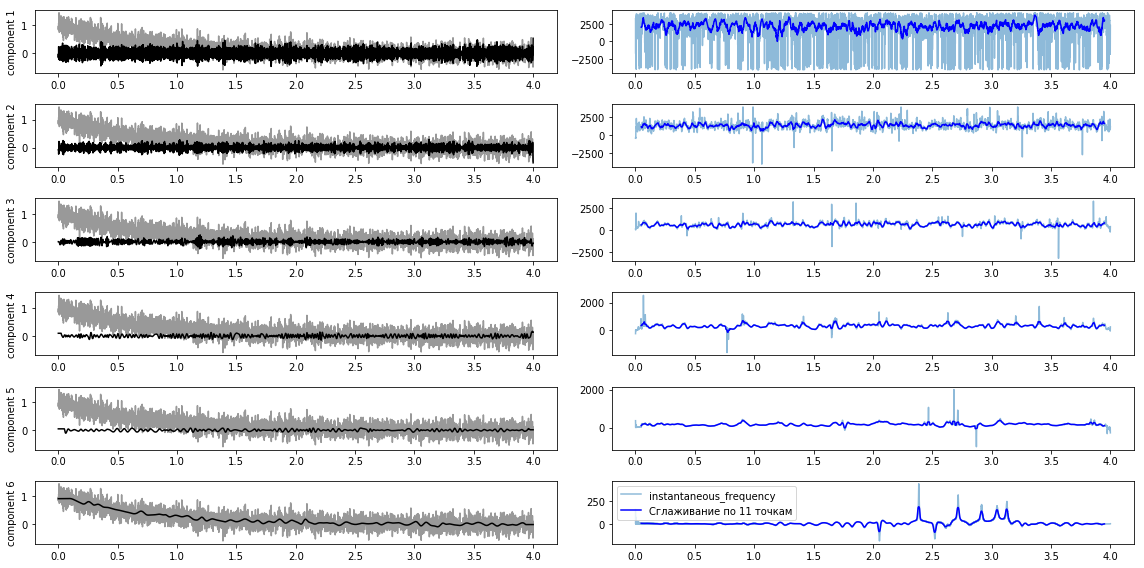

In [272]:
t = np.linspace(0, 4, 4096)
F = np.exp(-0.4*np.pi*t) + 0.2*rand.randn(len(t))
plot_emd(F, t, 5, 50, 515)